Code that makes pretty disconnected graphs with $M$ connected components using the RBF kernel

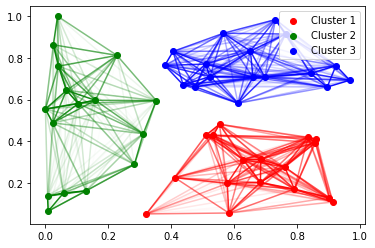

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

# Generate random data points
num_points = 50
x = np.random.rand(num_points, 2)

# Apply clustering algorithm
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters).fit(x)
labels = kmeans.labels_

# Calculate RBF kernel weights
gamma = 10.0  # kernel parameter
weights = rbf_kernel(x, gamma=gamma)

# Create graph
fig, ax = plt.subplots()
colors = ['r', 'g', 'b']
for i in range(num_clusters):
    idx = np.where(labels == i)[0]
    ax.scatter(x[idx, 0], x[idx, 1], c=colors[i], label='Cluster {}'.format(i+1))
    for j in idx:
        for k in idx:
            if j < k:
                ax.plot([x[j, 0], x[k, 0]], [x[j, 1], x[k, 1]], color=colors[i], alpha=weights[j, k])

ax.legend()
plt.show()

My attempt at GSSL

The accuracy of the predicted labels is given by: 1.0


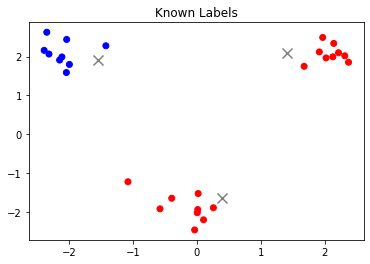

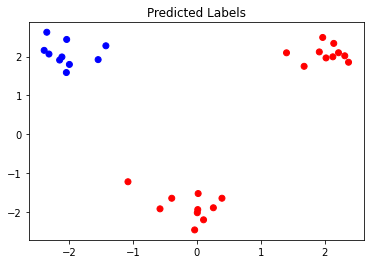

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

# define the kernel function
def kernel(x1, x2):
    return np.exp(-np.linalg.norm(x1 - x2)**2)

# generate some random training data
n = 30
X = np.zeros((n, 2))
X[:10] = np.random.multivariate_normal([2, 2], [[0.1, 0], [0, 0.1]], 10)
X[10:20] = np.random.multivariate_normal([-2, 2], [[0.1, 0], [0, 0.1]], 10)
X[20:] = np.random.multivariate_normal([0, -2], [[0.1, 0], [0, 0.1]], 10)

y = np.zeros(n)
y[:10] = 1
y[10:20] = -1
y[20:] = 1

# Initialize y_known vector with NaN values for unknown labels
y_known = np.full_like(y, np.nan)

# Set known label values for points 1, 5, and 9
known_indices = [3, 13, 23] # index 0 corresponds to point 1, index 4 corresponds to point 5, and so on
y_known[known_indices] = y[known_indices]

def loss(z, X, y, y_known, lambd, sigma):
    n = len(X)
    K = np.array([[kernel(X[i], X[j]) for j in range(n)] for i in range(n)])
    z = np.array(z)
    y_known_mask = np.isfinite(y_known)
    y_known = np.nan_to_num(y_known)
    y_known = np.array(y_known)
    loss_known = -np.sum(np.log(norm.cdf(y_known[y_known_mask] * z[y_known_mask])), axis=0)
    loss_unknown = -np.sum(np.log(norm.cdf(y[~y_known_mask] * z[~y_known_mask])), axis=0)
    return loss_known + loss_unknown + lambd * np.dot(z, np.dot(np.linalg.inv(K + sigma**2*np.eye(n)), z))

# set the hyperparameters
lambd = 1.0
sigma = 1.0

# set the initial guess for z
z0 = np.zeros(n)

# optimize for z
result = minimize(loss, z0, args=(X, y, y_known, lambd, sigma), method='BFGS')

# extract the optimized coefficients
z_star = result.x

# compute the optimized function values
K = np.array([[kernel(X[i], X[j]) for j in range(n)] for i in range(n)])
f_star = np.dot(K, np.dot(np.linalg.inv(K + sigma**2*np.eye(n)), z_star))

# compute predicted labels
epsilon = np.random.normal(0, 0.3, n)
y_pred = np.sign(f_star + epsilon)

# compute accuracy
accuracy = np.mean(y == y_pred)
print("The accuracy of the predicted labels is given by:",accuracy)


# Plot the dataset with known labels highlighted
plt.scatter(X[np.isnan(y_known), 0], X[np.isnan(y_known), 1], c=y[np.isnan(y_known)], cmap='bwr')
plt.scatter(X[~np.isnan(y_known), 0], X[~np.isnan(y_known), 1], c='gray', marker='x', s=100, linewidths=1.5)
plt.title('Known Labels')
plt.show()

# plot predicted labels
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='bwr')
plt.title('Predicted Labels')
plt.show()

The accuracy of the predicted labels is given by: 1.0


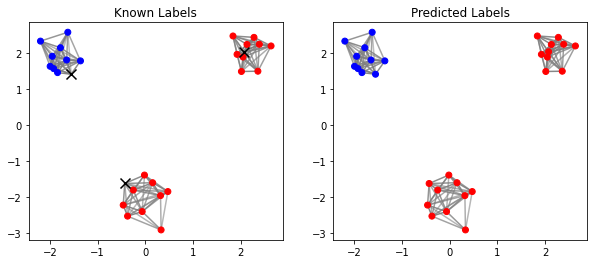

In [20]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

# generate some random training data
n = 30
X = np.zeros((n, 2))
X[:10] = np.random.multivariate_normal([2, 2], [[0.1, 0], [0, 0.1]], 10)
X[10:20] = np.random.multivariate_normal([-2, 2], [[0.1, 0], [0, 0.1]], 10)
X[20:] = np.random.multivariate_normal([0, -2], [[0.1, 0], [0, 0.1]], 10)

y = np.zeros(n)
y[:10] = 1
y[10:20] = -1
y[20:] = 1

# Initialize y_known vector with NaN values for unknown labels
y_known = np.full_like(y, np.nan)

# Set known label values for points 1, 5, and 9
known_indices = [3, 13, 23] # index 0 corresponds to point 1, index 4 corresponds to point 5, and so on
y_known[known_indices] = y[known_indices]

# set the hyperparameters
lambd = 1.0
sigma = 1.0

# compute the RBF kernel matrix
K = rbf_kernel(X, gamma=1/(2*sigma**2))

def loss(z, K, y, y_known, lambd):
    n = len(K)
    z = np.array(z)
    y_known_mask = np.isfinite(y_known)
    y_known = np.nan_to_num(y_known)
    y_known = np.array(y_known)
    loss_known = -np.sum(np.log(norm.cdf(y_known[y_known_mask] * z[y_known_mask])), axis=0)
    loss_unknown = -np.sum(np.log(norm.cdf(y[~y_known_mask] * z[~y_known_mask])), axis=0)
    return loss_known + loss_unknown + lambd * np.dot(z, np.dot(np.linalg.inv(K), z))

# set the initial guess for z
z0 = np.zeros(n)

# optimize for z
result = minimize(loss, z0, args=(K, y, y_known, lambd), method='BFGS')

# extract the optimized coefficients
z_star = result.x

# compute the optimized function values
f_star = np.dot(K, z_star)

# compute predicted labels
epsilon = np.random.normal(0, 0.3, n)
y_pred = np.sign(f_star + epsilon)

# compute accuracy
accuracy = np.mean(y == y_pred)
print("The accuracy of the predicted labels is given by:", accuracy)

# create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# add edges according to the RBF kernel
for i in range(n):
    for j in range(i+1, n):
        if K[i,j] > 0.5:
            axs[0].plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color='gray', alpha=K[i,j], zorder=0)
            axs[1].plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color='gray', alpha=K[i,j], zorder=0)

# plot original graph with known labels highlighted
axs[0].scatter(X[np.isnan(y_known), 0], X[np.isnan(y_known), 1], c=y[np.isnan(y_known)], cmap='bwr')
axs[0].scatter(X[~np.isnan(y_known), 0], X[~np.isnan(y_known), 1], c='k', marker='x', s=100, linewidths=1.5)
axs[0].set_title('Known Labels')

# plot predicted labels
axs[1].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='bwr')
axs[1].set_title('Predicted Labels')

plt.show()